# Notebook 4a: Poisson Equation - Analytical Validation

This notebook demonstrates how to validate the Poisson solver against known analytical solutions. We solve three progressively complex diffusion problems:

1. **Linear profile** - No source term (∇²u = 0)
2. **Quadratic profile** - Constant source term (∇²u = -2)
3. **Sinusoidal solution** - Variable source term (∇²u = -π²sin(πy))

For each case, we compare the numerical solution against the analytical solution and visualize the results.

In [1]:
#| echo: false
# This is required to fix pyvista 
# (visualisation) crashes in interactive notebooks (including on binder)

import nest_asyncio
nest_asyncio.apply()

In [2]:
#| output: false

import underworld3 as uw
import numpy as np
import sympy

import os
os.environ["SYMPY_USE_CACHE"] = "no"

## Example 1: Linear Temperature Profile

We solve the steady-state diffusion equation with no source term:

$$\nabla^2 u = 0$$

with boundary conditions:
- u(y=0) = 1 (bottom)
- u(y=1) = 0 (top)

The analytical solution is simply: $u(y) = 1 - y$

In [3]:
# Create a simple 2D mesh
mesh = uw.meshing.UnstructuredSimplexBox(cellSize=0.1)
x, y = mesh.X

# Create the temperature variable
u = uw.discretisation.MeshVariable("u", mesh, 1, vtype=uw.VarType.SCALAR, degree=2)

# Set up the Poisson solver
poisson = uw.systems.Poisson(mesh, u_Field=u)
poisson.constitutive_model = uw.constitutive_models.DiffusionModel
poisson.constitutive_model.Parameters.diffusivity = 1
poisson.f = 0.0  # No source term

# Apply boundary conditions
poisson.add_dirichlet_bc(1.0, "Bottom")
poisson.add_dirichlet_bc(0.0, "Top")

# Solve the system
poisson.solve()

print(f"Solver converged: {poisson.snes.getConvergedReason() > 0}")

Solver converged: True


### Validate against analytical solution

Sample the numerical solution along a vertical line through the center of the domain and compare with $u(y) = 1 - y$.

In [4]:
# Sample vertical profile through center
sample_y = np.linspace(0, 1, 20)
sample_x = np.zeros_like(sample_y) + 0.5
sample_points = np.column_stack([sample_x, sample_y])

# Evaluate numerical solution
u_numerical = uw.function.evaluate(u.sym[0], sample_points, rbf=False).squeeze()
u_analytical = 1 - sample_y

# Compute L2 error
error = np.sqrt(np.mean((u_numerical - u_analytical) ** 2))
print(f"L2 Error: {error:.3e}")
print(f"Max absolute error: {np.max(np.abs(u_numerical - u_analytical)):.3e}")

L2 Error: 1.261e-05
Max absolute error: 2.313e-05


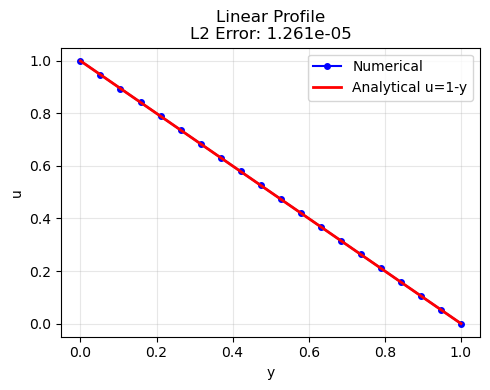

In [5]:
# Visualize the solution
import pyvista as pv
import underworld3.visualisation as vis

pvmesh = vis.mesh_to_pv_mesh(mesh)
pvmesh.point_data["T"] = vis.scalar_fn_to_pv_points(pvmesh, u.sym)

pl = pv.Plotter(window_size=(1000, 500), shape=(1, 2))

# Plot 1: 2D solution field
pl.subplot(0, 0)
pl.add_mesh(
    pvmesh,
    cmap="coolwarm",
    edge_color="Black",
    show_edges=True,
    scalars="T",
    show_scalar_bar=True,
)
pl.view_xy()

# Plot 2: Profile comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sample_y, u_numerical, 'bo-', label='Numerical', markersize=4)
ax.plot(sample_y, u_analytical, 'r-', label='Analytical u=1-y', linewidth=2)
ax.set_xlabel('y')
ax.set_ylabel('u')
ax.set_title(f'Linear Profile\nL2 Error: {error:.3e}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

pl.export_html("html5/poisson_linear_plot.html")
plt.savefig("media/poisson_linear_profile.png", dpi=150, bbox_inches='tight')
plt.show()

In [6]:
#| fig-cap: "Interactive Image: Linear temperature profile from Poisson solver with no source term"

from IPython.display import IFrame
IFrame(src="html5/poisson_linear_plot.html", width=800, height=400)

## Example 2: Quadratic Profile with Constant Source

Now we solve with a constant source term:

$$\nabla^2 u = -2$$

with boundary conditions:
- u(y=0) = 0
- u(y=1) = 0

The analytical solution is: $u(y) = y(1-y)$

In [7]:
# Create new mesh and variable
mesh2 = uw.meshing.StructuredQuadBox(elementRes=(10, 10))
x2, y2 = mesh2.X

u2 = uw.discretisation.MeshVariable("u2", mesh2, 1, vtype=uw.VarType.SCALAR, degree=2)

# Set up Poisson solver with source term
poisson2 = uw.systems.Poisson(mesh2, u_Field=u2)
poisson2.constitutive_model = uw.constitutive_models.DiffusionModel
poisson2.constitutive_model.Parameters.diffusivity = 1
poisson2.f = 2.0  # Constant source (note: -∇²u = f, so f=2 gives ∇²u = -2)

# Boundary conditions
poisson2.add_dirichlet_bc(0.0, "Bottom")
poisson2.add_dirichlet_bc(0.0, "Top")

poisson2.solve()

# Validate
u2_numerical = uw.function.evaluate(u2.sym[0], sample_points, rbf=False).squeeze()
u2_analytical = sample_y * (1 - sample_y)
error2 = np.sqrt(np.mean((u2_numerical - u2_analytical) ** 2))

print(f"L2 Error: {error2:.3e}")

Structured box element resolution 10 10
L2 Error: 7.151e-12


## Example 3: Sinusoidal Solution

Finally, we solve with a sinusoidal source term:

$$\nabla^2 u = -\pi^2 \sin(\pi y)$$

with boundary conditions:
- u(y=0) = 0  
- u(y=1) = 0

The analytical solution is: $u(y) = \sin(πy)$

This is a more challenging test as it requires the solver to capture the curvature of the sinusoidal function.

In [8]:
# Create mesh and variable
mesh3 = uw.meshing.StructuredQuadBox(elementRes=(12, 12))
x3, y3 = mesh3.X

u3 = uw.discretisation.MeshVariable("u3", mesh3, 1, vtype=uw.VarType.SCALAR, degree=2)

# Poisson solver with sinusoidal source
poisson3 = uw.systems.Poisson(mesh3, u_Field=u3)
poisson3.constitutive_model = uw.constitutive_models.DiffusionModel
poisson3.constitutive_model.Parameters.diffusivity = 1
poisson3.f = sympy.pi**2 * sympy.sin(sympy.pi * y3)  # Symbolic source term

# Boundary conditions
poisson3.add_dirichlet_bc(0.0, "Bottom")
poisson3.add_dirichlet_bc(0.0, "Top")

poisson3.solve()

# Validate
u3_numerical = uw.function.evaluate(u3.sym[0], sample_points, rbf=False).squeeze()
u3_analytical = np.sin(np.pi * sample_y)
error3 = np.sqrt(np.mean((u3_numerical - u3_analytical) ** 2))

print(f"L2 Error: {error3:.3e}")

Structured box element resolution 12 12
L2 Error: 7.096e-05


### Compare all three solutions

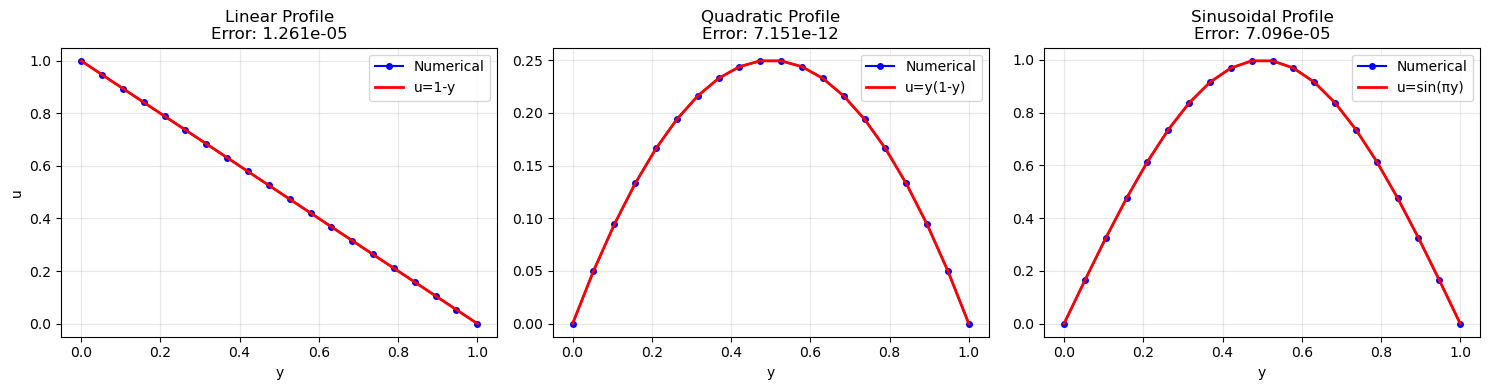

In [9]:
# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Linear profile
axes[0].plot(sample_y, u_numerical, 'bo-', label='Numerical', markersize=4)
axes[0].plot(sample_y, u_analytical, 'r-', label='u=1-y', linewidth=2)
axes[0].set_title(f'Linear Profile\nError: {error:.3e}')
axes[0].set_xlabel('y')
axes[0].set_ylabel('u')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Quadratic profile
axes[1].plot(sample_y, u2_numerical, 'bo-', label='Numerical', markersize=4)
axes[1].plot(sample_y, u2_analytical, 'r-', label='u=y(1-y)', linewidth=2)
axes[1].set_title(f'Quadratic Profile\nError: {error2:.3e}')
axes[1].set_xlabel('y')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sinusoidal profile
axes[2].plot(sample_y, u3_numerical, 'bo-', label='Numerical', markersize=4)
axes[2].plot(sample_y, u3_analytical, 'r-', label='u=sin(πy)', linewidth=2)
axes[2].set_title(f'Sinusoidal Profile\nError: {error3:.3e}')
axes[2].set_xlabel('y')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("media/poisson_validation_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## Summary

We have validated the Poisson solver against three analytical solutions and we can see that they work pretty well. 

- Applies Dirichlet boundary conditions
- Integrates source terms (constant and variable)
- Computes accurate gradients
- Handles both structured and unstructured meshes

These validation tests are essential for building confidence in more complex simulations where analytical solutions are not available.

## Exercise 4a.1

Try modifying the mesh resolution and polynomial degree to see how they affect the accuracy. For example:

- Change `cellSize` in `UnstructuredSimplexBox` from 0.1 to 0.05 or 0.2
- Change `degree` in the `MeshVariable` from 2 to 1 or 3

How does the error change with mesh refinement? With polynomial degree?

## Exercise 4a.2

Create a 2D analytical solution with variation in both x and y directions. For example:

$$u(x,y) = \sin(\pi x) \sin(\pi y)$$

What source term f(x,y) would produce this solution? Implement and validate it.

## Exercise 4a.2

We have analytic solutions with non-trivial gradients, you should recall from the previous notebook ([./4a-Poisson-Validation.ipynb](4-Solvers-i-Poisson.ipynb), that we can obtain a gradient using a projection solve:

```python
# Create Projection solver for gradient terms 

gradient = uw.systems.Projection(mesh, dTdY)
gradient.uw_function = t_soln.sym.diff(y)
gradient.smoothing = 1.0e-6
```

Try this and compare the results for the sinusoidal profile where the gradient can be determined analytically.
